## Face Generation using Wasserstein GAN

In this notebook we are going to implement WGAN for generating faces. The dataset is collected from Kaggle (<cite>https://www.kaggle.com/ashwingupta3012/human-faces</cite>).

Much like our previous notebooks we are going to use the Pytorch deep learning framework to implement our model.

The model we are going to formulate will be similar to that of Deep Convolution GAN but with some tweaks here and there.

So, lets get started.

**Disclaimer**: I have a habit of importing all the necessary packages in my first cell. So, don't be overwhelmed by it. Everything is explained whenever it is necessary.

In [1]:
## Importing the necessary packages ##

import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

With the necessary packages imported lets get our hands dirty with importing our dataset.

Now, since, we are going to implement the model just like our DCGAN one, we need our output to bear a config of 64 , 64 , 3 shape. 

So, keeping this in mind, to import our image data we need to apply the following transforms.

1. Resize
2. ToTensor
3. Normalize --> To get a value between [-1,1]

In [2]:
## Defining the transformations ##

trans = transforms.Compose([
    transforms.Resize((64 , 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5 , ) , (0.5 , ))
])

Now lets set up our dataset.

In [3]:
face_data = ImageFolder(root = 'humans',
                        transform = trans)

Boom! Its loaded.

Lets check the shape and also the highest and lowest values.

In [4]:
print('Number of Images :' , len(face_data))
print('Shape of Images :' , face_data[0][0].shape)
print('Maximum Value of Image :' , torch.max(face_data[111][0]))
print('Minimum Value of Image :' , torch.min(face_data[111][0]))

Number of Images : 7219
Shape of Images : torch.Size([3, 64, 64])
Maximum Value of Image : tensor(0.9216)
Minimum Value of Image : tensor(-1.)


And thats alright.
Max and Min value is in range [-1,1].

Now, its always better to visualize a sample of image.

Now, you might just go and try to display the image, but it doesn't happen like that.

Since, Pytorch keeps channels first and Matplotlib keeps channels at last, it is necessary to reshape before moving ahead. 

Furthermore, Matplotlib can display images in the range of [0 , 1], but our dataset has a range between [-1,1]. So we need to denormalize our images before moving ahead.

In [5]:
## Denormalization Function ##

def denorm_img(img):
    return img * 0.5 + 0.5

Now lets display an image!

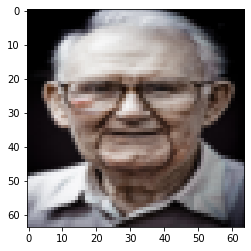

In [6]:
## Displaying an image ##

plt.imshow(denorm_img(face_data[0][0]).permute(1 , 2 , 0))
plt.show()

Now, lets built in our DataLoader.

In [7]:
## Loading our DataLoader ##

face_dataloader = DataLoader(face_data , 
                             batch_size = 16 ,
                             shuffle = True)

Lets check our DataLoader.

In [8]:
## The number of total batches of face dataloader ##

len(face_dataloader)

452

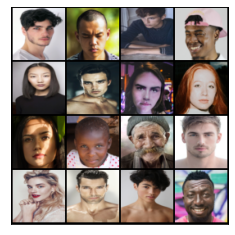

In [9]:
## Plotting one set of pictures ##

for img , _ in face_dataloader:
    figure , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(denorm_img(img) , 4).permute(1 , 2 , 0))
    plt.show()
    break

Boom! Its amazing!

I know I have squeezed the images but still they look awesome!

Now one thing is that we need to put our data to GPU, to make training efficient.

So, lets do that.

In [10]:
## Check for GPU availability ##

def check_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

## Transfer Data to device ##

def transfer_data(data , device):
    if isinstance(data , (list , tuple)):
        return [transfer_data(each_data , device) for each_data in data]
    return data.to(device , non_blocking = True)

Now that we have our transfer data function loaded.

Lets set our GPU DataLoader.

In [11]:
## GPU Dataloader ##

class gpu_dataloader():
    def __init__(self , dl , device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield transfer_data(batch , self.device)
            
    def __len__(self):
        return len(self.dl)

With all that out of the way, lets set our dataloader to a gpu dataloader.

In [12]:
## Getting the device ##

device = check_device()

## Setting GPU Datalaoders ##

face_dl = gpu_dataloader(face_dataloader , device)

And done!

Lets check the length of the Gpu Datalaoder to see if we have implemented it correctly.

And also visualize a batch of images of it.

In [13]:
## Checking the length of the dataloader ##

len(face_dl)

452

Yes! That matches.

Lets plot some images of a batch from our gpu dataloader.

In [14]:
## Setting the show images utility ##

def show_img(img_batch):
    figure , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(denorm_img(img_batch.to('cpu')) , 4).permute(1 , 2 , 0))
    plt.show()

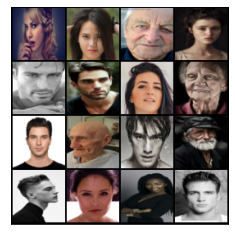

In [15]:
## Testing images ##

for img , _ in face_dl:
    show_img(img)
    break

Now its time that we implement our Generator and Discriminator.

In [16]:
## Defining Generator model ##

class Generator(nn.Module):
    def __init__(self , in_channel , out_channel , hidden_channel):
        super().__init__()
        self.in_channel = in_channel
        self.gen_model = nn.Sequential(
        self.gen_block(in_channel , hidden_channel * 16 , stride = 1 , kernel_size = 4 , padding = 0),
        self.gen_block(hidden_channel * 16 , hidden_channel * 8 , stride = 2 , kernel_size = 4 , padding = 1),
        self.gen_block(hidden_channel * 8 , hidden_channel * 4 , stride = 2 , kernel_size = 4 , padding = 1),
        self.gen_block(hidden_channel * 4 , hidden_channel * 2 , stride = 2 , kernel_size = 4 , padding = 1),
        nn.ConvTranspose2d(in_channels = hidden_channel * 2 , 
                           out_channels = out_channel , 
                           kernel_size = 4 , 
                           stride = 2 ,
                           padding = 1),
        nn.Tanh()
        )
        
    def gen_block(self , in_channel , out_channel , stride , kernel_size , padding):
        return nn.Sequential(
        nn.ConvTranspose2d(in_channels = in_channel , 
                           out_channels = out_channel , 
                           kernel_size = kernel_size , 
                           stride = stride ,
                           padding = padding),
        nn.BatchNorm2d(num_features = out_channel),
        nn.ReLU()
        )
    
    def forward(self , noise):
        noise = noise.view(noise.shape[0] , self.in_channel , 1 , 1)
        return self.gen_model(noise)
    

## Generating Noise ##

def gen_noise(batch_size , noise_dim):
    noise = torch.randn(batch_size , noise_dim)
    return noise

Now lets formulate the discriminator model.

In [17]:
## Defining the Critic Module ##

class Critic(nn.Module):
    def __init__(self , in_channel , out_channel , hidden_channel):
        super().__init__()
        self.critic_model = nn.Sequential(
        self.critic_block(in_channel , hidden_channel , kernel_size = 4 , stride = 2 , padding = 1),
        self.critic_block(hidden_channel , hidden_channel * 2 , kernel_size = 4 , stride = 2 , padding = 1),
        self.critic_block(hidden_channel * 2 , hidden_channel * 4 , kernel_size = 4 , stride = 2 , padding = 1),
        self.critic_block(hidden_channel * 4 , hidden_channel * 8 , kernel_size = 4 , stride = 2 , padding = 1),
        nn.Conv2d(in_channels = hidden_channel * 8,
                  out_channels = 1 , 
                  kernel_size = 4 , 
                  stride = 1 ,
                  padding = 0)
        )
        
    def critic_block(self , in_channel , out_channel , kernel_size , stride , padding):
        return nn.Sequential(
        nn.Conv2d(in_channels = in_channel,
                  out_channels = out_channel , 
                  kernel_size = kernel_size , 
                  stride = stride ,
                  padding = padding),
        nn.BatchNorm2d(out_channel),
        nn.LeakyReLU(0.2)
        )
    
    def forward(self , img):
        return self.critic_model(img)

Now lets instantiate the models.

In [18]:
## Generator Model Initialization ##

gen_model = Generator(100 , 3 , 64)

gen_model

Generator(
  (gen_model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding

In [19]:
## Critic Model Initialization ##

critic_model = Critic(3 , 1 , 64)

critic_model

Critic(
  (critic_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Co

Now with the model instantiated its better to apply the initial weights initializer and also transfer them into GPU if available.

In [20]:
## Initiliazing Weights ##

def initialize(m):
    if isinstance(m , (nn.Conv2d , nn.ConvTranspose2d)):
        torch.nn.init.normal_(m.weight , 0.0 , 0.02)
        
    if isinstance(m , nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight , 0.0 , 0.02)
        torch.nn.init.constant_(m.bias , 0.0)
        
gen = gen_model.apply(initialize)
critic = critic_model.apply(initialize)

In [21]:
## Transferring models to GPU ##

gen = gen.to(device)
critic = critic.to(device)

Let check a batch of fake generated image and visaulize it.

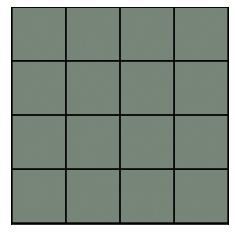

In [22]:
const_noise = torch.randn(16 , 100).to(device)

gen_img = gen(const_noise).detach()
show_img(gen_img)

And done!! We have done our bit for model creation.

Now, upto this point the code is somewhat similar to that of the DCGAN, but from the next point onwards its going to be a bit different.

So lets get going!!

In [23]:
## Gradient calculation ##

def grad_cal(real , fake , epsilon , critic):
    
    mixed_img = real * epsilon + fake * (1 - epsilon) 
    
    mixed_score = critic(mixed_img)
    
    grad = torch.autograd.grad(outputs = mixed_score , 
                               inputs = mixed_img , 
                               grad_outputs = torch.ones_like(mixed_score) ,
                               create_graph = True ,
                               retain_graph = True)[0]
    
    return grad

Now that we have calculated the gradients, lets initialize the gradient penalty for training the critic.

In [24]:
## Gradient Penalty ##

def grad_penalty(gradient):
    
    grad = gradient.view(len(gradient) , -1)
    
    grad_norm = grad.norm(2 , dim = 1)
    
    grad_penalty = torch.mean((grad_norm - 1) ** 2)
    
    return grad_penalty

Now lets set our Loss Functions.

In [25]:
## Generator Loss ##

def gen_loss(pred):
    
    loss = -(torch.mean(pred))
    
    return loss

## Discriminator Loss ##

def disc_loss(real , pred , grad_pen , reg_lambda):
    
    loss = -(torch.mean(real) - torch.mean(pred)) + reg_lambda * grad_pen
    
    return loss

Let set the optimizer for both the models.

In [26]:
## Generator Optimizer ##

gen_opt = torch.optim.Adam(gen.parameters() , lr = 0.0002 , betas = (0.5 , 0.999))

## Critic Optimizer ##

critic_opt = torch.optim.Adam(critic.parameters() , lr = 0.0002 , betas = (0.5 , 0.999))

Lets Train!!

C:\Users\Arijit\anaconda3\envs\pytorch_env\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch : [1 / 50] --> Discriminator Loss : 280.4362 , Generator Loss : -3.7309


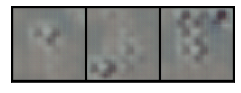

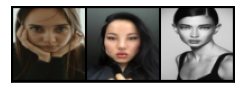

Epoch : [2 / 50] --> Discriminator Loss : 40.7483 , Generator Loss : 390.5274


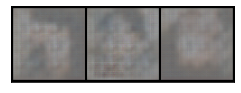

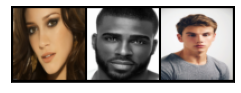

Epoch : [3 / 50] --> Discriminator Loss : 1097.2367 , Generator Loss : 325.7129


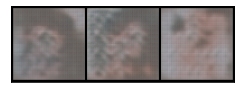

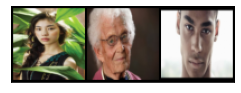

Epoch : [4 / 50] --> Discriminator Loss : -38.2939 , Generator Loss : 250.2139


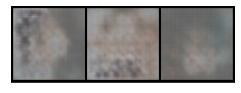

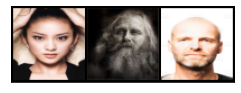

Epoch : [5 / 50] --> Discriminator Loss : 1.0030 , Generator Loss : 389.9800


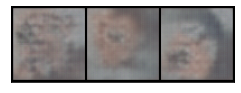

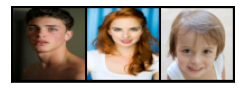

Epoch : [6 / 50] --> Discriminator Loss : -21.4658 , Generator Loss : 1371.2644


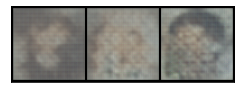

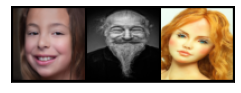

Epoch : [7 / 50] --> Discriminator Loss : 21.0059 , Generator Loss : 1109.5070


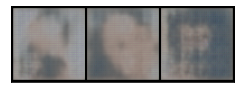

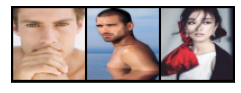

Epoch : [8 / 50] --> Discriminator Loss : 7.4556 , Generator Loss : 1583.0291


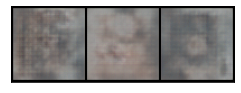

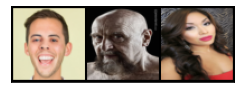

Epoch : [9 / 50] --> Discriminator Loss : -7.2013 , Generator Loss : 1480.3895


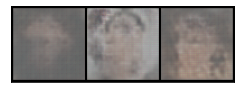

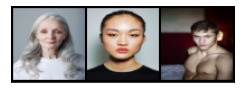

Epoch : [10 / 50] --> Discriminator Loss : 64.8333 , Generator Loss : 1487.4966


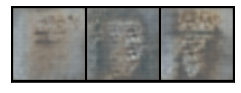

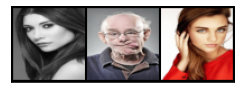

Epoch : [11 / 50] --> Discriminator Loss : -3.3023 , Generator Loss : 1479.7279


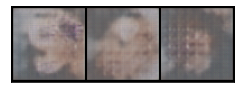

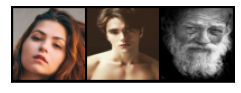

Epoch : [12 / 50] --> Discriminator Loss : -8.4965 , Generator Loss : 2344.7051


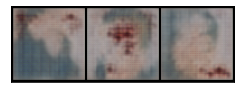

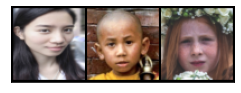

Epoch : [13 / 50] --> Discriminator Loss : -44.2779 , Generator Loss : 3092.7227


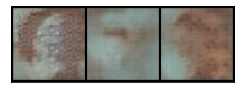

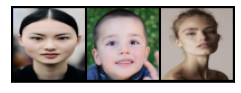

Epoch : [14 / 50] --> Discriminator Loss : 2.2251 , Generator Loss : 3274.9949


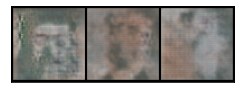

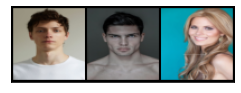

Epoch : [15 / 50] --> Discriminator Loss : 64.9287 , Generator Loss : 3276.7510


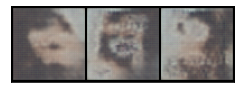

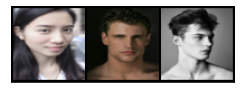

Epoch : [16 / 50] --> Discriminator Loss : 390.7322 , Generator Loss : 3252.4822


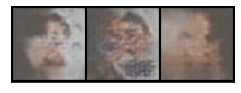

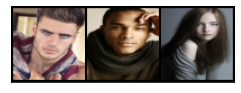

Epoch : [17 / 50] --> Discriminator Loss : 50.4890 , Generator Loss : 3147.5596


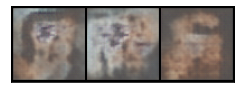

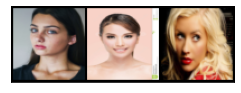

Epoch : [18 / 50] --> Discriminator Loss : 54.3046 , Generator Loss : 3264.8960


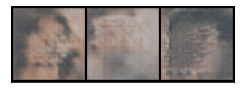

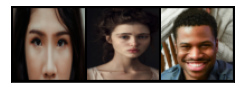

Epoch : [19 / 50] --> Discriminator Loss : 10.4368 , Generator Loss : 3671.1880


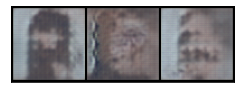

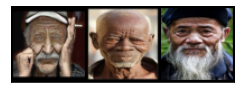

Epoch : [20 / 50] --> Discriminator Loss : 229.0480 , Generator Loss : 3626.7908


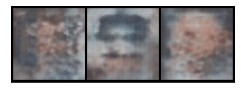

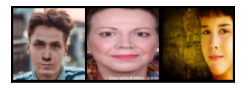

Epoch : [21 / 50] --> Discriminator Loss : 1.6827 , Generator Loss : 3647.7598


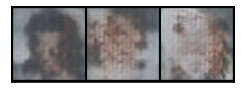

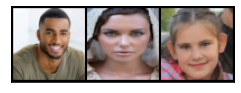

Epoch : [22 / 50] --> Discriminator Loss : 58.0089 , Generator Loss : 3681.6511


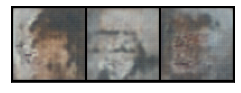

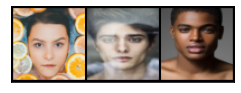

Epoch : [23 / 50] --> Discriminator Loss : 204.7244 , Generator Loss : 4352.4609


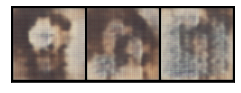

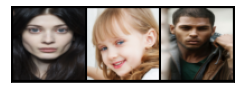

Epoch : [24 / 50] --> Discriminator Loss : -10.6751 , Generator Loss : 4375.9082


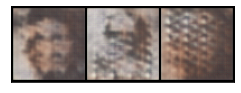

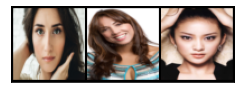

Epoch : [25 / 50] --> Discriminator Loss : 231.0791 , Generator Loss : 4322.9990


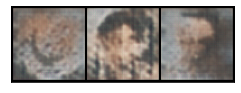

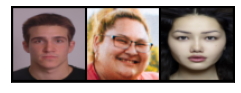

Epoch : [26 / 50] --> Discriminator Loss : -13.8968 , Generator Loss : 4513.2500


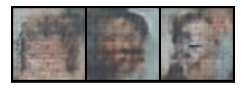

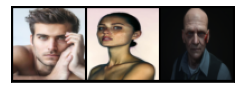

Epoch : [27 / 50] --> Discriminator Loss : 272.4861 , Generator Loss : 4527.0586


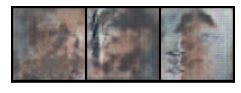

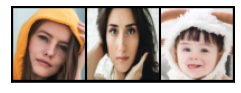

Epoch : [28 / 50] --> Discriminator Loss : 116.5010 , Generator Loss : 4927.7236


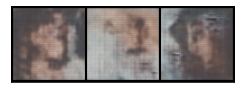

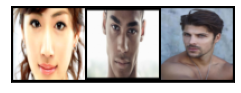

Epoch : [29 / 50] --> Discriminator Loss : -1.1465 , Generator Loss : 4765.9893


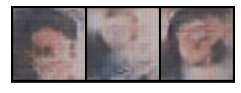

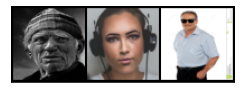

Epoch : [30 / 50] --> Discriminator Loss : 111.7990 , Generator Loss : 4719.5400


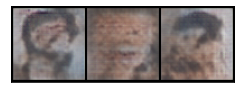

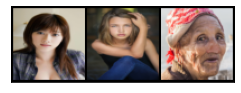

Epoch : [31 / 50] --> Discriminator Loss : 2132.5046 , Generator Loss : 4826.6592


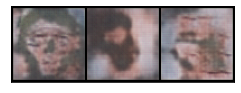

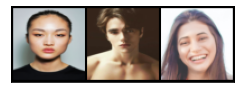

Epoch : [32 / 50] --> Discriminator Loss : -3.6751 , Generator Loss : 4768.7891


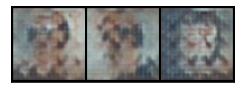

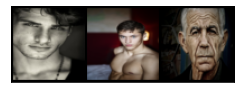

Epoch : [33 / 50] --> Discriminator Loss : -8.3033 , Generator Loss : 4719.9189


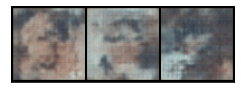

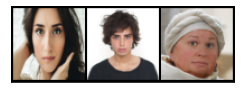

Epoch : [34 / 50] --> Discriminator Loss : -40.7501 , Generator Loss : 5257.1479


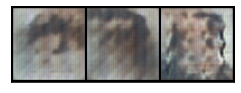

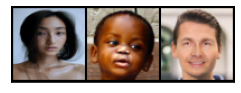

Epoch : [35 / 50] --> Discriminator Loss : -180.1673 , Generator Loss : 5511.9707


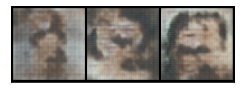

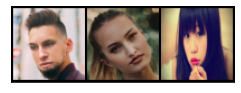

Epoch : [36 / 50] --> Discriminator Loss : 20.9139 , Generator Loss : 5256.4248


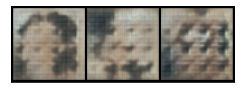

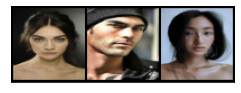

Epoch : [37 / 50] --> Discriminator Loss : 268.1239 , Generator Loss : 4676.0732


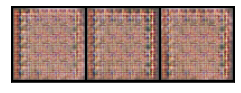

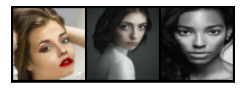

Epoch : [38 / 50] --> Discriminator Loss : -8.5197 , Generator Loss : 4738.0308


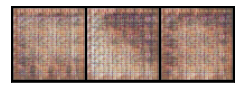

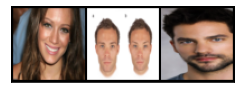

Epoch : [39 / 50] --> Discriminator Loss : 289.4207 , Generator Loss : 4762.8516


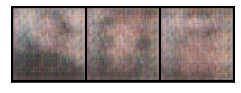

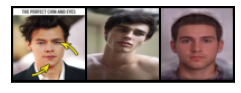

Epoch : [40 / 50] --> Discriminator Loss : 277.9712 , Generator Loss : 5013.5327


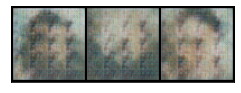

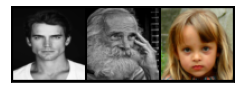

Epoch : [41 / 50] --> Discriminator Loss : 2024.2942 , Generator Loss : 5104.9102


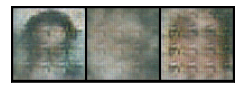

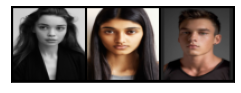

Epoch : [42 / 50] --> Discriminator Loss : 181.2393 , Generator Loss : 5578.6396


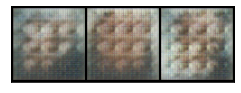

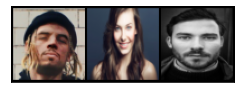

Epoch : [43 / 50] --> Discriminator Loss : 67.2783 , Generator Loss : 6311.0049


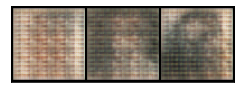

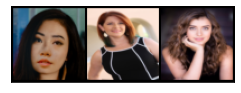

Epoch : [44 / 50] --> Discriminator Loss : 146.3419 , Generator Loss : 6343.1328


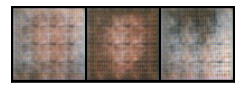

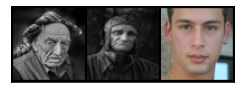

Epoch : [45 / 50] --> Discriminator Loss : 4523.8047 , Generator Loss : 7485.7344


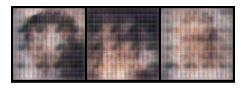

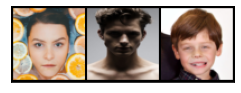

Epoch : [46 / 50] --> Discriminator Loss : 262.5940 , Generator Loss : 7135.0889


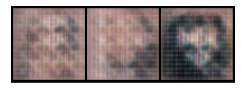

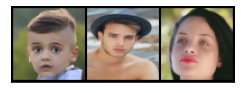

Epoch : [47 / 50] --> Discriminator Loss : -5.4510 , Generator Loss : 7117.7129


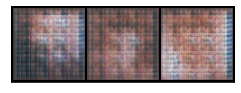

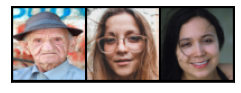

Epoch : [48 / 50] --> Discriminator Loss : 195.8179 , Generator Loss : 7047.6914


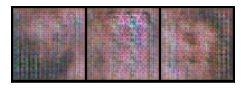

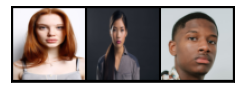

Epoch : [49 / 50] --> Discriminator Loss : 182.5535 , Generator Loss : 7047.0986


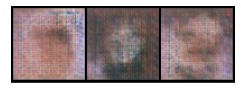

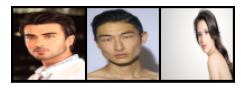

Epoch : [50 / 50] --> Discriminator Loss : -207.4316 , Generator Loss : 7039.3569


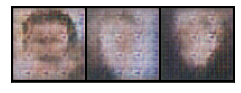

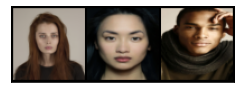

In [27]:
## Training the model ##

num_epochs = 50
reg_lambda = 10

## To train critic more than the generator ##
crit_repeat = 5

for epoch in range(num_epochs):
    
    for img , _ in face_dl:
        
        batch_size = len(img)
        
        for _ in range(crit_repeat):
            
            noise = gen_noise(batch_size , noise_dim = 100).to(device)
            fake_img = gen(noise).detach()
            
            critic_fake_pred = critic(fake_img)
            critic_real_pred = critic(img)
            
            epsilon = torch.randn(batch_size , 1 , 1 , 1 , requires_grad = True).to(device)
            
            grad = grad_cal(img , fake_img , epsilon , critic)
            
            gp = grad_penalty(grad)
            
            critic_opt.zero_grad()
            
            critic_loss = disc_loss(critic_real_pred , critic_fake_pred , gp , reg_lambda)
            
            critic_loss.backward(retain_graph = True)
            
            critic_opt.step()
            
        gen_opt.zero_grad()
        
        noise = gen_noise(batch_size , noise_dim = 100).to(device)
        fake_img = gen(noise)
            
        crit_fake_pred = critic(fake_img)
        
        gent_loss = gen_loss(crit_fake_pred)
        
        gent_loss.backward()
        
        gen_opt.step()
        
    print('Epoch : [{} / {}] --> Discriminator Loss : {:.4f} , Generator Loss : {:.4f}'.format(epoch + 1 , num_epochs , critic_loss.item() , gent_loss.item()))
    
    rand_noise = gen_noise(batch_size , noise_dim = 100).to(device)
    fake_img = gen(noise).detach()
    
    show_img(fake_img)
    
    show_img(img)